# Instructions
In `dibecs_3.3.0` run
+ `conda install -c conda-forge python-graphviz`
+ `pip install pydot "pymc3>=3.11" "calibr8>=5.0.3"`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import calibr8
import cutisplit
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 3.11.2
calibr8 6.0.2


In [3]:
DCS_EXPERIMENT = "Pahpshmir_MTP-Screening-PETase"
RUN_ID = "BQ5169"
analyser = run_analysis.CutisplitAnalysis(DCS_EXPERIMENT, RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)

## Model inputs
The model reproduces the experimental layout and dilutions of samples/standards that go into the assays.
This layout should be given in a `DataFrame`, indexed by the `input_well` ID (the DWP well) and having columns `"type"` and `"concentration_factor"`.

The `"type"` should represent the kind of sample.
`"concentration_factor"` allows you to analyze different dilutions at the same time.

In [4]:
df_inputs = analyser.get_df_inputs()
df_inputs.head()

,type,concentration_factor
input_well,,
A01,reference,1.0
A02,reference,0.201053
A03,reference,0.041053
A04,reference,1.0
A05,reference,0.201053


We'll need at least one dataset - Cutinase, split-GFP or both.
The cutinase dataset should be represented as a DataFrame:

In [5]:
df_cutinase = analyser.get_df_cutinase()
df_cutinase.head()

time   value
well cycle                  
A01  1      0.000000  0.4006
     2      1.360367  0.4154
     3      2.720667  0.4128
     4      4.081050  0.4156
     5      5.441350  0.4176

To translate between absorbance readings and product concentration, the model needs a `calibr8` calibration model for p-Nitrophenol absorbance/concentration.
This calibration model was fitted in a separate notebook.

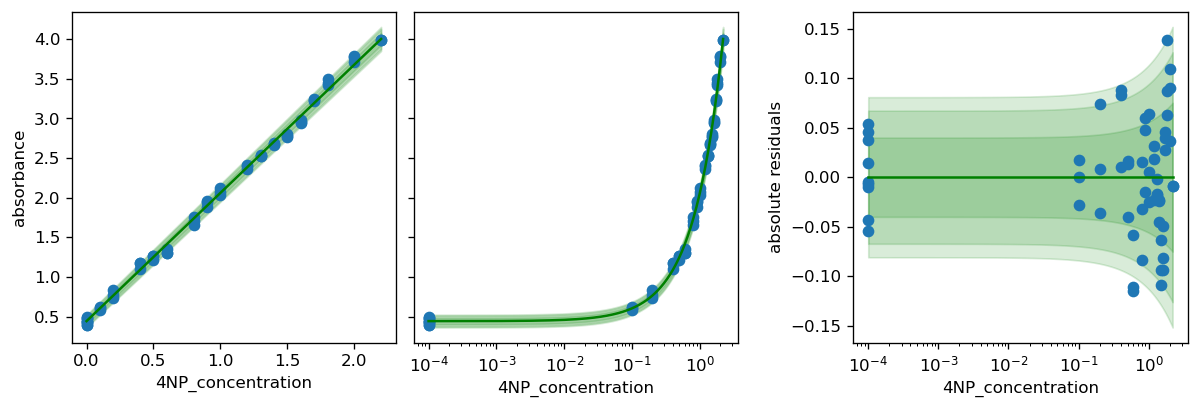

In [6]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol);

Also the split-GFP dataset should be a single DataFrame. For the split-GFP we'll also use time time-delay between pipetting and measurement to further inform the model.

In [7]:
df_sgfp, t0_delta = analyser.get_df_sgfp()
df_sgfp.head()

2021-08-10 11:18:24+00:00
The MTP was pipetted at 2021-08-10 11:18:24+00:00 (0.68 hours before the end of the first measurement).
!! Overriding t0_delta with 0.25 hours !!


well,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
time_hours,,,,,,,,,,,,,,,,,,,,,
0.000000,265.0,275.0,291.0,295.0,299.0,306.0,301.0,304.0,299.0,300.0,...,284.0,294.0,286.0,290.0,290.0,297.0,304.0,310.0,313.0,449.0
0.801944,274.0,285.0,297.0,301.0,304.0,312.0,306.0,310.0,306.0,309.0,...,299.0,302.0,298.0,298.0,294.0,300.0,322.0,316.0,324.0,488.0
1.603889,277.0,291.0,299.0,303.0,296.0,306.0,303.0,318.0,304.0,296.0,...,294.0,293.0,299.0,292.0,292.0,297.0,300.0,311.0,311.0,462.0
2.405833,288.0,313.0,312.0,318.0,325.0,319.0,326.0,327.0,321.0,324.0,...,313.0,307.0,316.0,305.0,308.0,310.0,322.0,329.0,336.0,488.0
3.207778,278.0,282.0,297.0,303.0,298.0,295.0,299.0,304.0,302.0,304.0,...,289.0,293.0,288.0,301.0,287.0,283.0,298.0,308.0,313.0,445.0


## Creating the Model
The model is initialized from the `df_inputs` that explains the structure of the dataset, plus the observations from cutinase assay, split-GFP assay or both.

In [8]:
model = cutisplit.CombinedModel(
    df_inputs,
    df_cutinase=df_cutinase,
    cm_nitrophenol=cm_nitrophenol,
    df_sgfp=df_sgfp,
    t0_delta=t0_delta,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

type                (1,)	reference
input_well          (48,)	A01, A02, A03, …, H06
assay_well          (96,)	A01, A02, A03, …, H12
cutinase_cycle      (30,)	0, 1, 2, …, 29
sgfp_cycle          (21,)	0, 1, 2, …, 20
assay_column        (12,)	01, 02, 03, …, 12


The PyMC3 model can be visualized as a graph:

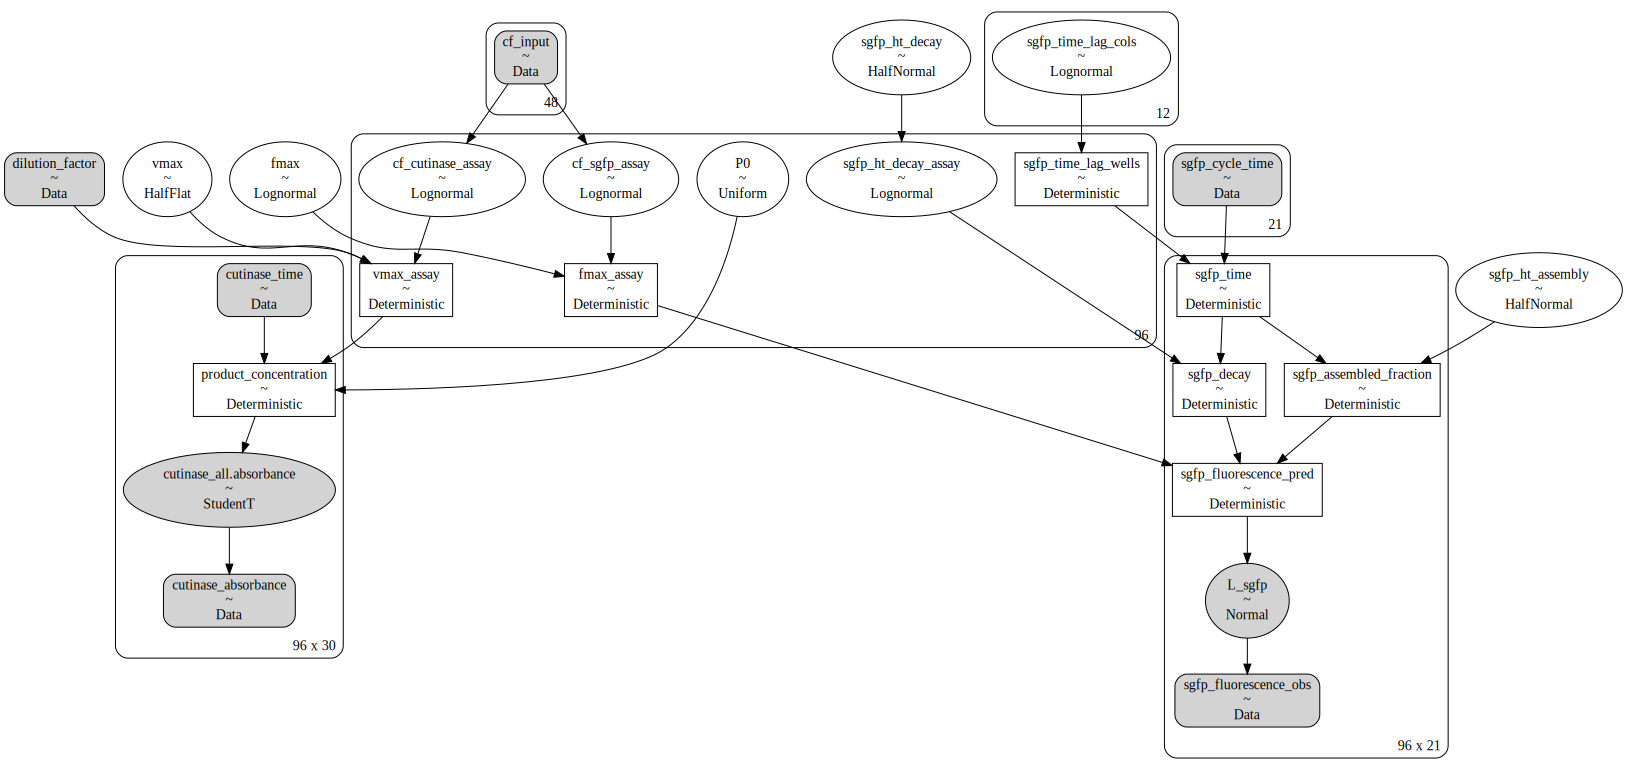

In [9]:
pymc3.model_to_graphviz(model.pmodel)

In [11]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sgfp_ht_decay_assay, sgfp_ht_decay, sgfp_ht_assembly, fmax, sgfp_time_lag_cols, P0, vmax, cf_sgfp_assay, cf_cutinase_assay]


RuntimeError: Chain 3 failed.

The result should be saved such that the analysis can run in another notebook.

In [ ]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result.nc") 